In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MultiLabelBinarizer
from get_metrics import get_metrics_regression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import re
from transliterate import translit

from sklearn.metrics import mean_absolute_error, mean_squared_error, f1_score, \
    roc_auc_score, r2_score, log_loss, mean_squared_log_error

import warnings
from warnings import simplefilter

warnings.filterwarnings("ignore")
simplefilter("ignore", category=RuntimeWarning)

RAND = 10

In [2]:
df=pd.read_json('cian_data.json')

In [3]:
df.head(5)

,room_count,price,district,area,street,house,metro,time_metro,facilities,floor,attic,square,transport_type
0,3,80000,ЦАО,Пресненский,Мукомольный проезд,2,Шелепиха,10,"[Можно с животными, Можно с детьми, Ванна, Сти...",15,36,65,пешком
1,3,55000,ЦАО,Мещанский,Банный пер.,4С1,Проспект Мира,5,"[Можно с животными, Можно с детьми, Ванна, Сти...",7,9,60,пешком
2,3,220000,ЦАО,Пресненский,Большая Никитская ул.,49,Баррикадная,10,"[Можно с детьми, Ванна, Стиральная машина, Пос...",9,14,100,пешком
3,3,150000,ЦАО,Пресненский,Большой Козихинский пер.,4,Пушкинская,7,"[Можно с животными, Можно с детьми, Стиральная...",2,4,80,пешком
4,3,350000,ЦАО,Арбат,ул. Новый Арбат,32,Смоленская,7,"[Можно с животными, Можно с детьми, Ванна, Сти...",4,13,110,пешком


In [4]:
df.describe()

,room_count,price,time_metro,floor,attic,square
count,24387.000000,2.438700e+04,24387.000000,24387.000000,24387.000000,24387.000000
mean,2.167548,1.082806e+05,9.419363,8.473162,16.028089,88.082421
std,1.139089,1.554696e+05,6.345109,8.127670,12.686037,1367.136704
min,0.000000,1.000000e+04,1.000000,1.000000,1.000000,10.000000
25%,1.000000,4.300000e+04,5.000000,4.000000,9.000000,40.000000
50%,2.000000,6.000000e+04,9.000000,6.000000,14.000000,55.000000
75%,3.000000,1.100000e+05,12.000000,11.000000,19.000000,82.000000
max,6.000000,3.000000e+06,110.000000,84.000000,97.000000,170000.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24387 entries, 0 to 24388
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   room_count      24387 non-null  int64 
 1   price           24387 non-null  int64 
 2   district        24387 non-null  object
 3   area            24387 non-null  object
 4   street          24387 non-null  object
 5   house           24339 non-null  object
 6   metro           24042 non-null  object
 7   time_metro      24387 non-null  int64 
 8   facilities      24387 non-null  object
 9   floor           24387 non-null  int64 
 10  attic           24387 non-null  int64 
 11  square          24387 non-null  int64 
 12  transport_type  23645 non-null  object
dtypes: int64(6), object(7)
memory usage: 2.6+ MB


In [6]:
df.describe(include=['object'])

,district,area,street,house,metro,facilities,transport_type
count,24387,24387,24387,24339,24042,24387,23645
unique,9,120,1860,2305,297,937,2
top,ЦАО,Пресненский,1-й Красногвардейский проезд,3,Смоленская,"[Можно с детьми, Ванна, Стиральная машина, Меб...",пешком
freq,5241,1596,418,669,341,1382,21517


# Линейная регрессия.

## Предобработка.

In [7]:
df = df.drop(['house', 'street'], axis=1)

In [8]:
df['metro'] = df['metro'].fillna('Unknown')
df['transport_type'].fillna(df['transport_type'].mode(), inplace=True)

Распределение ненормальное


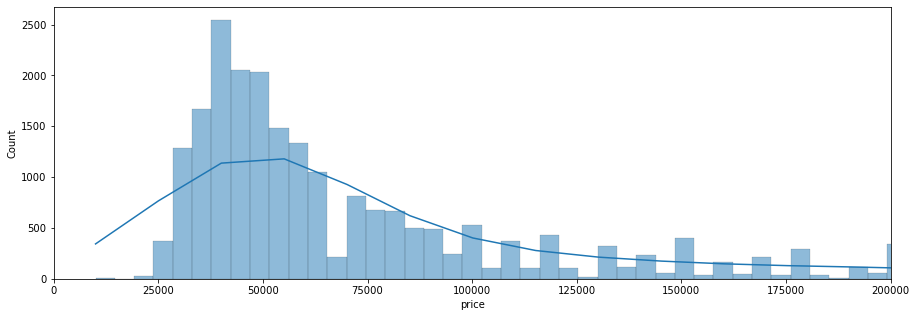

In [9]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.histplot(df['price'], kde=True)
ax.set_xlim(0, 200000)

if stats.shapiro(df.price).pvalue >= 0.05:
    print('Распределение нормальное')
else:
    print('Распределение ненормальное')

In [10]:
df['price_log'] = np.log(df.price)

Распределение ненормальное


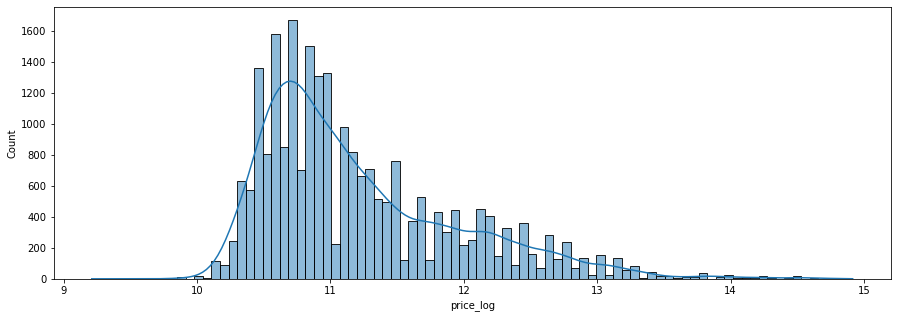

In [11]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.histplot(df.price_log, kde=True)

if stats.shapiro(df.price_log).pvalue >= 0.05:
    print('Распределение нормальное')
else:
    print('Распределение ненормальное')

In [12]:
# бинаризуем столбец facilities
mlb = MultiLabelBinarizer()
df_bin = pd.DataFrame(mlb.fit_transform(df['facilities']),
                      columns=mlb.classes_,
                      index=df.index)
df_bin = df_bin.drop('Душевая кабина', axis=1)
df_lin = pd.concat([df, df_bin], axis=1)
df_lin = df_lin.drop(['facilities'], axis=1)
df_lin = pd.get_dummies(df_lin, drop_first=True)

In [13]:
df_lin.shape

(24387, 443)

In [14]:
#удаляем признаки с корреляцией выше 0.89
corr_matrix = df_lin.corr()
high_corr_cols = set()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > 0.89:
            colname = corr_matrix.columns[i]
            high_corr_cols.add(colname)
df_lin.drop(high_corr_cols, axis=1, inplace=True)

In [15]:
df_lin.shape

(24387, 440)

## Обучение модели.

In [16]:
X = df_lin.drop(columns=['price', 'price_log'], axis=1)
y = df_lin['price_log']
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.20,
                                                    shuffle=True,
                                                    random_state=RAND)

std = StandardScaler()
X_train_std = std.fit_transform(X_train)
X_test_std = std.transform(X_test)
y_train_exp = np.exp(y_train)
y_test_exp = np.exp(y_test)

In [17]:
lr_std = LinearRegression()
lr_std.fit(X_train_std, y_train)

LinearRegression()

In [18]:
def check_overfitting(model, X_train, y_train, X_test, y_test, metric_fun):
    """
    Проверка на overfitting для регрессии
    """
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    value_train = metric_fun(y_train, y_pred_train)
    value_test = metric_fun(y_test, y_pred_test)

    print(f'{metric_fun.__name__} train: %.3f' % value_train)
    print(f'{metric_fun.__name__} test: %.3f' % value_test)
    print(f'delta = {(abs(value_train - value_test)/value_test*100):.1f} %')

In [19]:
y_pred_std = lr_std.predict(X_test_std)

metrics = get_metrics_regression(y_test_exp,
                                 y_pred_std,
                                 X_test_std,
                                 name='Lin Test')

In [20]:
check_overfitting(lr_std, X_train_std, y_train_exp, X_test_std, y_test_exp, mean_squared_error)

mean_squared_error train: 37989547368.288
mean_squared_error test: 5009871604474901954560.000
delta = 100.0 %


In [21]:
metrics

,model,MAE,MSE,RMSE,RMSLE,R2 adjusted,MPE_%,MAPE_%,WAPE_%
0,Lin Test,2.026956e+09,5.009872e+21,7.078045e+10,8.725869,-3.221079e+11,-2.496898e+06,2.497098e+06,1.985957e+06


# Random Forest

## Предобработка.

In [114]:
df = pd.read_json('cian_data.json')
df = df.drop(['house', 'street'], axis=1)
df[['metro', 'transport_type']] = df[['metro',
                                      'transport_type']].fillna('Unknown')

mlb = MultiLabelBinarizer()
df_bin = pd.DataFrame(mlb.fit_transform(df['facilities']),
                      columns=mlb.classes_,
                      index=df.index)
df_bin = pd.concat([df, df_bin], axis=1)
df_bin = df_bin.drop(['facilities'], axis=1)
df_bin = pd.get_dummies(df_bin)

X = df_bin.drop(columns=['price'], axis=1)
y = df_bin['price']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.20,
                                                    shuffle=True,
                                                    random_state=RAND)

## Обучение модели.

In [80]:
rfr = RandomForestRegressor(random_state=RAND,
                            verbose=1,
                            criterion='mae',
                            n_jobs=-1)
rfr.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 25.1min finished


RandomForestRegressor(criterion='mae', n_jobs=-1, random_state=10, verbose=1)

In [81]:
y_pred = rfr.predict(X_test)

metrics = metrics.append(
    get_metrics_regression(y_test, y_pred, X_test,
                           'RandomForestRegressor Test'))

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


In [82]:
check_overfitting(rfr, X_train, y_train, X_test, y_test, mean_absolute_error)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


mean_absolute_error train: 8322.868
mean_absolute_error test: 19752.408
delta = 57.9 %


In [84]:
metrics

,model,MAE,MSE,RMSE,RMSLE,R2 adjusted,MPE_%,MAPE_%,WAPE_%
0,Lin Test,2.026956e+09,5.009872e+21,7.078045e+10,8.725869,-3.221079e+11,-2.496898e+06,2.497098e+06,1.985957e+06
0,RandomForestRegressor Test,1.975241e+04,2.409945e+09,4.909120e+04,0.227525,8.447386e-01,-6.042063e+00,1.730181e+01,1.935288e+01


# Gradient boosting

## LightGBM Baseline

In [117]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24387 entries, 0 to 24388
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   room_count      24387 non-null  int64 
 1   price           24387 non-null  int64 
 2   district        24387 non-null  object
 3   area            24387 non-null  object
 4   metro           24387 non-null  object
 5   time_metro      24387 non-null  int64 
 6   facilities      24387 non-null  object
 7   floor           24387 non-null  int64 
 8   attic           24387 non-null  int64 
 9   square          24387 non-null  int64 
 10  transport_type  24387 non-null  object
dtypes: int64(6), object(5)
memory usage: 2.2+ MB


In [118]:
mlb = MultiLabelBinarizer()
df_bi = pd.DataFrame(mlb.fit_transform(df["facilities"]),
                      columns=mlb.classes_,
                      index=df.index)
df = pd.concat([df, df_bi], axis=1)
df = df.drop(["facilities"], axis=1)

In [119]:
df.loc[:, df.dtypes == "object"] = df.select_dtypes(
    ["object"]).apply(lambda x: x.astype("category"))

In [120]:
cols_translit = [
    translit(x, language_code='ru', reversed=True).replace(' ', '_')
    for x in df.columns
]

df.columns = cols_translit
df = df.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x))

In [121]:
X = df.drop(['price'], axis=1)
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    random_state=RAND)

X_train_, X_val, y_train_, y_val = train_test_split(X_train,
                                                    y_train,
                                                    test_size=0.16,
                                                    shuffle=True,
                                                    random_state=RAND)

In [122]:
lgb = LGBMRegressor(random_state=RAND, objective='mae')
eval_set = [(X_val, y_val)]

lgb.fit(X_train_,
        y_train_,
        eval_metric="mae",
        eval_set=eval_set,
        verbose=False,
        early_stopping_rounds=100)

y_pred = lgb.predict(X_test)

In [123]:
check_overfitting(lgb, X_train_, y_train_, X_test, y_test, mean_absolute_error)

mean_absolute_error train: 22843.573
mean_absolute_error test: 22702.340
delta = 0.6 %


In [124]:
metrics = metrics.append(
    get_metrics_regression(y_test, y_pred, X_test, 'LGBM Test'))

metrics

,model,MAE,MSE,RMSE,RMSLE,R2 adjusted,MPE_%,MAPE_%,WAPE_%
0,Lin Test,2.026956e+09,5.009872e+21,7.078045e+10,8.725869,-3.221079e+11,-2.496898e+06,2.497098e+06,1.985957e+06
0,RandomForestRegressor Test,1.975241e+04,2.409945e+09,4.909120e+04,0.227525,8.447386e-01,-6.042063e+00,1.730181e+01,1.935288e+01
0,LGBM Test,2.270234e+04,4.903732e+09,7.002665e+04,0.237266,7.117907e-01,-2.236760e+00,1.678097e+01,2.224315e+01


## CatBoost Baseline

In [125]:
cat_f = X_val.select_dtypes("category").columns.tolist()

cat = CatBoostRegressor(random_state=RAND,
                        eval_metric="MAE",
                        cat_features=cat_f)

eval_set = [(X_val, y_val)]

cat.fit(X_train_,
        y_train_,
        eval_set=eval_set,
        verbose=False,
        early_stopping_rounds=100)

y_pred = cat.predict(X_test)

In [126]:
check_overfitting(cat, X_train_, y_train_, X_test, y_test, mean_absolute_error)

mean_absolute_error train: 18357.162
mean_absolute_error test: 21845.731
delta = 16.0 %


In [127]:
metrics = metrics.append(
    get_metrics_regression(y_test, y_pred, X_test, 'Cat Test'))

metrics

,model,MAE,MSE,RMSE,RMSLE,R2 adjusted,MPE_%,MAPE_%,WAPE_%
0,Lin Test,2.026956e+09,5.009872e+21,7.078045e+10,8.725869,-3.221079e+11,-2.496898e+06,2.497098e+06,1.985957e+06
0,RandomForestRegressor Test,1.975241e+04,2.409945e+09,4.909120e+04,0.227525,8.447386e-01,-6.042063e+00,1.730181e+01,1.935288e+01
0,LGBM Test,2.270234e+04,4.903732e+09,7.002665e+04,0.237266,7.117907e-01,-2.236760e+00,1.678097e+01,2.224315e+01
0,Cat Test,2.184573e+04,2.752059e+09,5.246008e+04,0.237001,8.382519e-01,-5.686587e+00,1.838766e+01,2.140387e+01


**Для подбора гиперпараметров будут взяты CatBoost и LightGBM**